# Image compressibility using optimal hard threshold

High dimensionality is a typical problem in processing large data sets, for example audio, video and images. 

Here, as an example, let's consider grayscale images as a real-valued matrix with large number of pixels - the elements of a high-dimensional vector space. Most images are highly compressible, which means that the relevant information may be represented in lower dimensions.

We will use an SVD to generate compact approximations of the image. SVD is guaranteed to exist for any matrix and provides a hierarchical representation of the data (in terms of a new coordinate system defined by most important correlations). 

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os

#### Consider a grayscale image

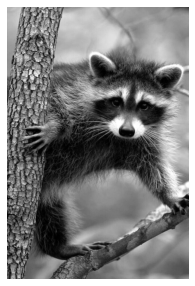

shape = 960 x 640
rank = 640


In [2]:
A = imread(os.path.join('raccoon.jpg'))
X = np.mean(A, -1); # Convert RGB to grayscale

plt.rcParams['figure.figsize'] = [9, 5]
img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()
print ('shape =', X.shape[0], 'x', X.shape[1])
print ('rank =', np.linalg.matrix_rank(X))

Let's decompose the image matrix to **SVD** and consider if the image is recognizable at different ranks, from lower to higher values. 

Although, depending on the task, at this moment we assume a general recognition of images, like whether its an animate or inanimate object. Surely, if we want to differ one raccooon from another we need to leave more features.

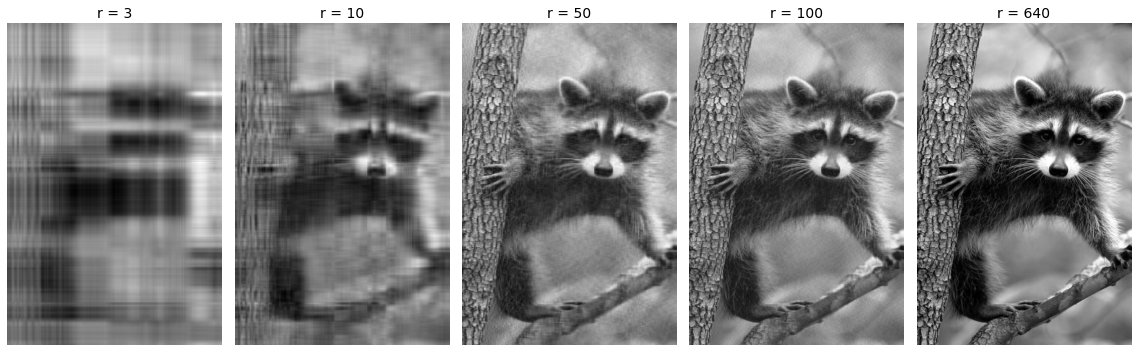

In [3]:
U, S, VT = np.linalg.svd(X,full_matrices=False)
S = np.diag(S)

fig=plt.figure(figsize=(16, 5))
for i, r in enumerate([3, 10, 50, 100, 640]):
    fig.add_subplot(1, 5, i+1)
    Xapprox = U[:,:r] @ S[0:r,:r] @ VT[:r,:] # let's construct an approximate image
    img = plt.imshow(Xapprox)
    img.set_cmap('gray')
    plt.axis('off')
    plt.title('r = ' + str(r), fontsize = 14)
    fig.tight_layout()
plt.show()

Every time we add ranks $r$ to the image, we see that it becomes less and less informative to us (you can see the concave and increasing nature of cumulative sum of image's singular values below). **So do we really need to store all of the features?**

Well, we want a few singular values as possible to describe the data, but there is always a balance in modelling between complexity and accuracy: if we have higher rank $r$ we have more accurate, but more complex model; if we have lower rank $r$ we have a less accurate, but less complex model. 

So we are looking for the optimal spot where we get the most of the information from the image, but without overfitting for some of the little features we don't care about.

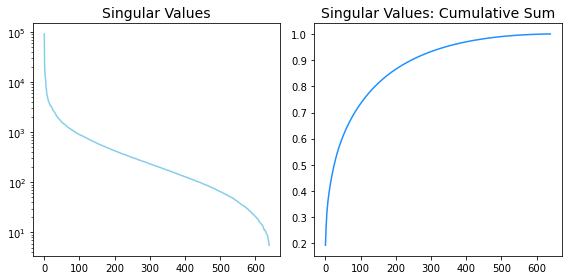

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].semilogy(np.diag(S), color='skyblue')
axes[0].set_title('Singular Values', fontsize = 14)

axes[1].plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)), color='dodgerblue')
axes[1].set_title('Singular Values: Cumulative Sum', fontsize = 14)
fig.tight_layout()

Thus, the most important decision we need to take is **how many many singular values to keep, i.e. where to truncate**. 
Truncation may be viewed as a threshold on singular values, where values larger than a threshold are kept, while remaining
are truncated. 
We may consider many factors, like the desired rank of the system and the distribution of the singular values. 
We can use a common technique that truncates the SVD at a rank that captures the 90% of the cumulatve sum of singular values. 
Sometimes we can find an 'elbow' in the singular value distribution which can help to extract important patterns from noise. 

Let's implement the results from a recent research by M. Gavish and D. L. Donoho, **"The optimal hard threshold for singular values is $\frac{4}{\sqrt{3}}$"** (DOI: 10.1109/TIT.2014.2323359) that defines the optimum hard threshold for singular value truncation based on the assumption that the matrix has a low-level structure polluted with Gaussian white noise:

$$X = X_{signal} + \sigma X_{noise}$$

$X_{noise}$ is assumed to be i.i.d. Gaussian random variables with zero mean and unit variance.  
$\sigma$ - magnitude of the noise.

### When the noise magnitude is known:   

1. If X is a square matrix $X \in \mathbb{R}^{n x n}$, then:  
  
  optimum hard threshold is $\tau = \frac{4}{\sqrt{3}}\sqrt{n}\sigma$

2. If X is a rectangular and $m$ ≪ $n$, then the constant $\frac{4}{\sqrt{3}}$ is replaced by a function of the aspect ratio $\lambda(\beta)$:  
  $\tau = \lambda(\beta)\sqrt{n}\sigma$  
  
  $\beta = \frac{m}{n}$, or $\frac{n}{m}$ if $n$ ≪ $m$
  
  $\lambda(\beta) = \sqrt{2(\beta + 1) + \frac{8\beta}{(\beta + 1) + \sqrt{\beta^{2} + 14\beta + 1}}}$
  
  Note when $\beta = 1$:  $\lambda(1) = \frac{4}{\sqrt{3}}$

This $\lambda(\beta)$ is one of the main results of the research made by M. Gavish and D. L. Donoho. There are 5 theorems and 5 lemmas dedicated to prooving and measuring the denoising performance of a singular value shrinkage denoiser $\hat{X}$ of original matrix $Y_n$ by its difference with the signal matrix $X_n$ in Frobenius norm and in an asymptotic framework:

$M(\hat{X}, x)\stackrel{\text{a.s.}}{=} \lim\limits_{n\to\infty} \| \hat{X_{\lambda}}(Y_n)-X_n\|^{2}_F $

where $M(\hat{X}, x)$ is an asymptotic MSE of singular value hard threshold.

Proof of the Theorem 4 offers to denote by $x_{*}(\lambda)$ the unique positive solution to the equation $(x+\frac{1}{x})(x+\frac{\beta}{x}) = \lambda^2$, which comes from the proof of Lemma 4, where the $x_{*}(\lambda) = \sqrt{\frac{\lambda^2 - \beta - 1 + \sqrt{(\lambda^2 - \beta - 1)-4\beta}}{2}}$ and $arg\min\limits_{\lambda>1+\beta}\max\limits_{x \in \mathbb{R}^r} M(\hat{X}, x) = \sqrt{2(\beta + 1) + \frac{8\beta}{(\beta + 1) + \sqrt{\beta^{2} + 14\beta + 1}}}$. The equation from Lemma 4 itself refers to the formulas 9 and 10 of a research of F. Benaych-Georges and R. R. Nadakuditi, "The singular values and vectors of low rank perturbations of large rectangular random matrices" (https://doi.org/10.1016/j.jmva.2012.04.019). 

This $\lambda (\beta)$ helps us understand that it is by ~15-20% above the right bound of Marchenko-Pastur distribution (signal eigenvalues lie right after this bound). 

It is said that: "When some data singular value $y_i$ is too close to the bulk, its corresponding singular vectors are too badly rotated, and the rank-one matrix $u_i y_i v^{'}_i$ it contributes to the denoiser hurts the AMSE more than it helps.The optimal threshold $\lambda (\beta)$ keeps such singular values out of the picture; this is why it is necessarily larger than the bulk edge."

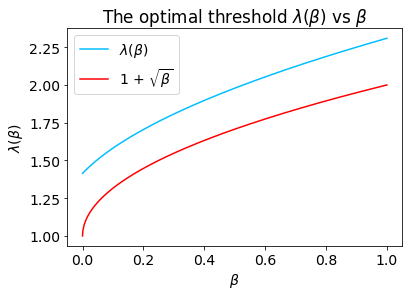

In [62]:
import math
plt.figure(figsize=(6,4))

beta = np.linspace(0,1,1000)
lambda_beta = np.sqrt(2*(beta + 1) + (8*beta)/(beta + 1 + np.sqrt(beta**2 + 14*beta + 1)))
right_bulk = 1 + np.sqrt(beta)

plt.plot(beta, lambda_beta, label=r'$\lambda (\beta)$', color='deepskyblue')
plt.plot(beta, right_bulk, label=r'1 + $\sqrt{\beta}$', color='red')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$\lambda (\beta)$')
plt.title('The optimal threshold ' + r'$\lambda (\beta)$' + ' vs ' + r'$\beta$')
plt.legend()
plt.show()

Sometimes the best way to check the theory is to check it on the example where we already now the answer. We will truncate the matrix by some threshold, add some random noise, then truncate by the optimal threshold and look if the formula works. Let's consider the first case with the square matrix (case with rectangualar matrix will be considered later):

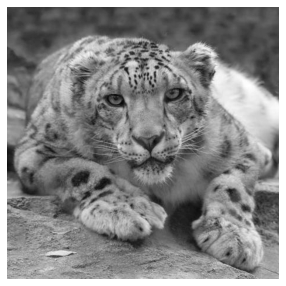

shape = 463 x 463
rank = 463


In [6]:
A = imread(os.path.join('irbis.jpg')) 
X_orig = np.mean(A, -1); # Convert RGB to grayscale

img = plt.imshow(X_orig)
img.set_cmap('gray')
plt.axis('off')
plt.show()
print ('shape =', X_orig.shape[0], 'x', X_orig.shape[1])
print ('rank =', np.linalg.matrix_rank(X_orig))

1) Let's trucate it with the first 20 singular values (desc sorting):

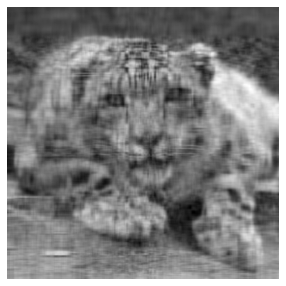

rank = 20


In [7]:
U, S, VT = np.linalg.svd(X_orig,full_matrices=False)
r=20
X_true = U[:,:r] @ np.diag(S[:r]) @ VT[:r,:]
plt.imshow(X_true)
plt.set_cmap('gray')
plt.axis('off')
plt.show()
print ('rank =', np.linalg.matrix_rank(X_true))

2) Then add some random noise, for example with std = 20 for better visual effect:

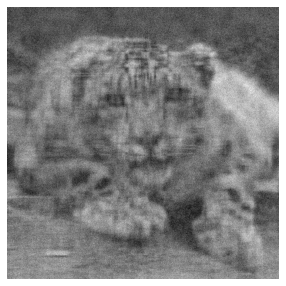

rank = 463


In [8]:
sigma = 20
X_noisy = X_true + sigma*np.random.randn(*X_true.shape)
plt.imshow(X_noisy)
plt.set_cmap('gray')
plt.axis('off')
plt.show()
print ('rank =', np.linalg.matrix_rank(X_noisy))

3) Now let's assume that a resulting image is our inital matrix that we need to denoise, and truncate by the threshold derived in the formulas above:

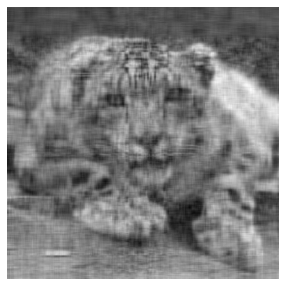

hard threshold: y = 993.85, x = 20
rank = 20


In [9]:
U_n, S_n, VT_n = np.linalg.svd(X_noisy,full_matrices=0)
N = X_noisy.shape[0]
cutoff = (4/np.sqrt(3)) * np.sqrt(N) * sigma #hard threshold
r_n = np.max(np.where(S_n > cutoff))

X_clean = U_n[:,:(r_n+1)] @ np.diag(S_n[:(r_n+1)]) @ VT_n[:(r_n+1),:]
plt.imshow(X_clean)
plt.set_cmap('gray')
plt.axis('off')
plt.show()
print ('hard threshold: y = ' + "{:.5}".format(cutoff) + ', ' + 'x = ' + str(r_n+1))
print ('rank =', np.linalg.matrix_rank(X_clean))

Let's consider the cutoff in the scatterplots: 

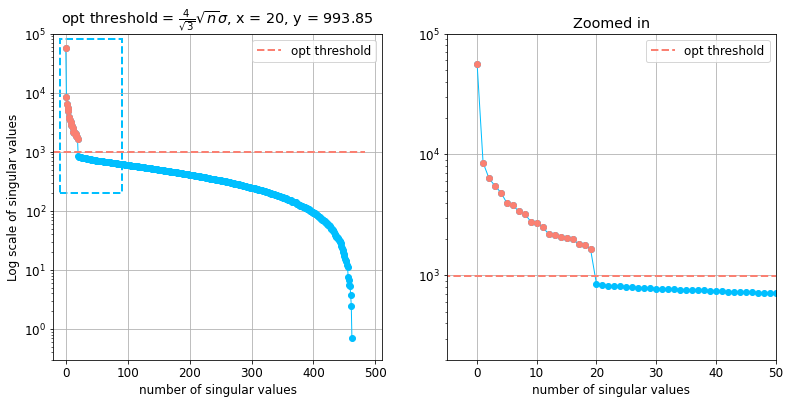

In [10]:
import matplotlib.patches as patches
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams.update({'font.size': 12})
## Plot Singular Values
plt.figure(figsize=(20, 6))


plt.subplot(1, 3, 1)
plt.semilogy(S_n,'-o', color='deepskyblue', linewidth=1)
plt.semilogy(np.diag(S_n[:r]),'o', color='salmon', linewidth=2)
plt.plot(np.array([-20, N+20]),np.array([cutoff, cutoff]),'--', color='salmon', linewidth=2, label='opt threshold')
rect = patches.Rectangle((-10,200),100,80000,lw=2,ls='--',fc='none',ec='deepskyblue')
plt.gca().add_patch(rect)
plt.xlabel('number of singular values')
plt.ylabel('Log scale of singular values')
plt.xlim((-20,510))
plt.ylim((0.3,100000))
plt.legend()
plt.title("opt threshold = " + r"$ \frac{4}{\sqrt{3}} {\sqrt{n}} \sigma $, " + "x = " + str(r_n+1) +", "+ "y = "+ "{:.5}".format(cutoff))
plt.grid()

plt.subplot(1, 3, 2)
plt.semilogy(S_n,'-o', color='deepskyblue', linewidth=1)
plt.semilogy(np.diag(S_n[:r]),'o', color='salmon', linewidth=1)
plt.plot(np.array([-20, N+20]),np.array([cutoff, cutoff]),'--', color='salmon', linewidth=2, label='opt threshold')
plt.xlabel('number of singular values')
plt.xlim((-5,50))
plt.ylim((200,100000))
plt.legend()
plt.title("Zoomed in")
plt.grid()

Above we see that the formula works and we can even visually distinguish the signal from noise.

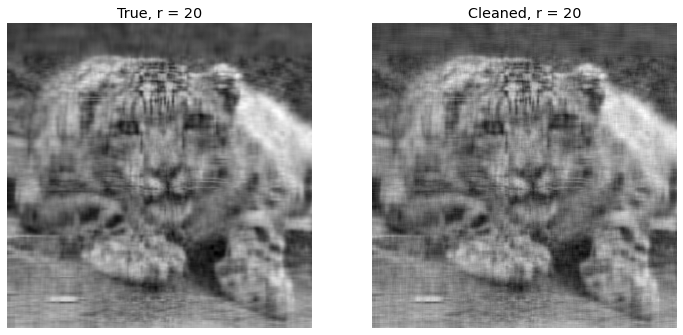

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams.update({'font.size': 12})

plt.subplot(1, 2, 1)
plt.imshow(X_true)
plt.set_cmap('gray')
plt.axis('off')
plt.title('True, r = ' + str(r))

plt.subplot(1, 2, 2)
plt.imshow(X_clean)
plt.set_cmap('gray')
plt.axis('off')
plt.title('Cleaned, r = '+ str(r_n+1))
plt.show()

#### Conclusion 1: Cleaned version is more or less close to the true image truncated by threshold = 20.

### Now let's consider when the noise magnitude is unknown:   

For unknown noise $\sigma$, and a rectangular matrix $X \in \mathbb{R}^{m x n}$, the optimal hard threshold is given by:

  $\tau = \omega(\beta)\sigma_{med}$, where 
  
  $\sigma_{med}$ is a median singular value.  
  Here $\omega(\beta)= \Large\frac{\lambda(\beta)}{\sqrt{\mu_{\beta}}}$

where ${\mu_{\beta}}$ is the median of the **Marchenko-Pastur distribution**, namely, the unique solution (solutions must be approximated numerically) in $\beta_{-} \leq {\mu_{\beta}} \leq \beta_{+}$ to the following equation:

$$\int\limits_{\beta_{-}}^{{\mu_{\beta}}} \frac{\sqrt{(\beta_{+}-t)(t-\beta_{-})}}{2\pi\beta t}dt = \frac{1}{2}$$

where $\beta_{\pm} = (1{\pm}\sqrt{\beta})^2$  

### 1) First, let's consider the calculation of ${\mu_{\beta}}$ in datails, 
namely look at the distribution of eigenvalues of covariance matrix from large random matrices:

Here is a simple function to calculate the covariance matrix:

$$Cov = \frac{1}{n-1} \sum^{n}_{i=1}{(X_i-\bar{X})(X_i-\bar{X})^T}$$

However, in most cases of spectral analysis of large dimensional random
matrices, the sample covariance matrix is simply defined as:

$$Cov = \frac{XX^T}{n}$$

In [12]:
# Covariance matrix
def cov(a):
    return (a @ a.T)/a.shape[1]

If we have some completely random data, for example:

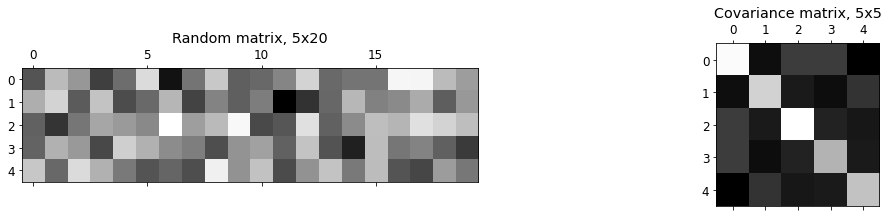

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 3))

np.random.seed(123)
X_rand=np.random.normal(size=(5,20))
axes[0].matshow(X_rand);
axes[0].set_title('Random matrix, 5x20')

axes[1].matshow(cov(X_rand));
axes[1].set_title('Covariance matrix, 5x5');

Let's find the eigen values of this covariance matrix:

In [14]:
# Return the eigenvalues and eigenvectors of a real symmetric matrix:
e_vals, _ = np.linalg.eigh(cov(X_rand))

In [15]:
# In this case the e_vals array contains
e_vals

array([0.80299025, 0.96669733, 1.19683305, 1.47675383, 1.92503284])

We see that the eigen values are random just as the input matrix, but what is their distribution?  
Well it tends to the **Marchenko-Pastur distribution**:

$$
P(t) = \frac{ \sqrt{(\beta_+ - t)(t-\beta_-)} }{2 \pi \beta t}1_{x\in \left[\beta_-, \beta_+\right]}$$

where $\beta=m/n$,   
$m$ is the number of rows in the matrix,  
$n$ is the number of columns,  
$\beta_+ = (1+\sqrt{\beta})^2$ and $\beta_- = (1-\sqrt{\beta})^2$.  

Let's describe the continuous part of the distribution:

In [16]:
def marchpast(t, beta):  
    def ewm(a):
        return np.maximum(a, np.zeros_like(a)) #Element-wise maximum of array elements.
    beta_plus = (1 + beta**0.5)**2
    beta_minus = (1 - beta**0.5)**2
    return np.sqrt(ewm(beta_plus  - t) * ewm(t- beta_minus)) / ( 2*np.pi*beta*t)

**Calculating the empirical eigenvalue distribution**  
Here is a simple demonstration in Python that the eigenvalues indeed tend to this distribution and which gives an idea of the inaccuracy of the distribution for finite sized matrices.

Since we are trying to find the distribution empirically we need generate a number of sample of covariance matrices as follows:

In [17]:
def random_cov(m, n, cov_m): #cov - lots of covariance matrices of random matrices of m x n shape
    r=[]
    for i in range(cov_m):
        x=np.random.normal(size=(m,n)) #for normal distribution
        r.append(cov(x))
    return np.array(r) #Returns  cov x n x n array

In [18]:
def EE(a, beta): #"Calculate and show histogram of eigenvalues"
    
    ee, ev=np.linalg.eigh(a)
    plt.figure(figsize=(6,4))
    nn, bb, patches=plt.hist(ee.ravel(), 
                                bins="auto", 
                                density=True, label='empirical', color="orchid")
    x=np.arange(bb[0], bb[-1], 0.003)
    plt.plot(x, marchpast(x, beta),label='theoretical', color='lime')

    #plt.ylim(top=nn[1:].max() * 1.2)
    plt.xlabel('eigenvalues of random matrix cov')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

**Results**  
Below is what the empirical distribution looks like for the above case of a 
$5×30$ matrix, i.e., $n=5$, $m=30$. It can be seen that it follows roughly the expected Marchenko-Pastur but that some deviations are clear, especially that tails are more extended.

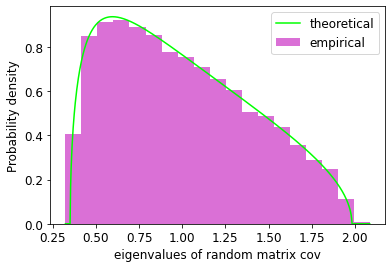

In [19]:
EE(random_cov(50,300,50), 50/300)

The reason for this is that Marchenko-Pastur is derived in limit $m\rightarrow\infty$, $n\rightarrow\infty$.  
The discrepancy is however not large and already by $m=50$, $n=300$ it is quite small:

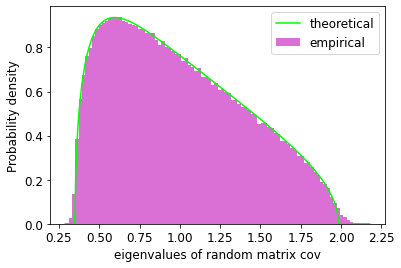

In [20]:
EE(random_cov(50,300,5000), 50/300)

If you seeing a wide distribution of eighenvalues in your covariance matrices its unlikely due to be to the large $m$, $n$ limit!

### 2) Second, let's consider the abovementioned image as a rectangular matrix
to which we a going to find an optimal hard threshold when noise is unknown:

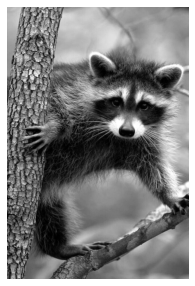

In [21]:
img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()

Let's first of all define the **integral**: 

In [22]:
import math
from math import sqrt, pi
from scipy import integrate

def Marcenko_Pastur_Integral(x,beta):
    
    lobnd = (1 - sqrt(beta))**2
    hibnd = (1 + sqrt(beta))**2

    dens = lambda t: sqrt((hibnd - t)*(t - lobnd))/(2*pi*beta*t)
    I, er = integrate.quad(dens,lobnd,x)

    return I

then find the $\beta$:

In [23]:
image = X 
m = np.min(image.shape)
n = np.max(image.shape)
beta = m/n

and, finally, find approximate solutions numerically:

In [24]:
import scipy.optimize
mu_median = scipy.optimize.broyden1(lambda x: Marcenko_Pastur_Integral(x,beta)-1/2, 1.0, f_tol=1e-6)
mu_median

array(0.77237598)

In [25]:
def EE_mu(a, beta, median):
    "Calculate and show histogram of eigenvalues"
    ee, ev=np.linalg.eigh(a)
    plt.figure(figsize=(6,4))
    nn, bb, patches=plt.hist(ee.ravel(), 
                                bins="auto", 
                                density=True, label='empirical', color="mediumspringgreen")
    x=np.arange(bb[0], bb[-1], 0.003)
    plt.plot(x, marchpast(x, beta),label='theoretical', color="deepskyblue",)
    plt.axvline(median, color='blue', linewidth=1, alpha=0.8, label='mu_median')
    plt.xlabel('eigenvalues of random matrix cov')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

plot empirical distribution:

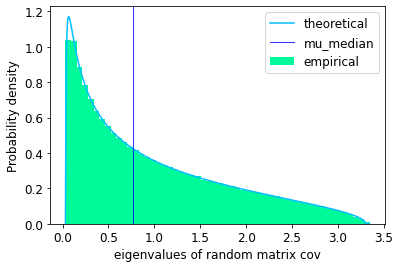

In [27]:
EE_mu(random_cov(m,n,100), beta, mu_median)

To be sure, we can calculate both areas which mu_median divides by supose equal parts:

In [28]:
Marcenko_Pastur_Integral(mu_median,beta), 1-Marcenko_Pastur_Integral(mu_median,beta)

(0.5000000002643034, 0.49999999973569664)

Yes, they are almost equal.

### 3) Finally, let's find the optimal hard threshold and compare two images:

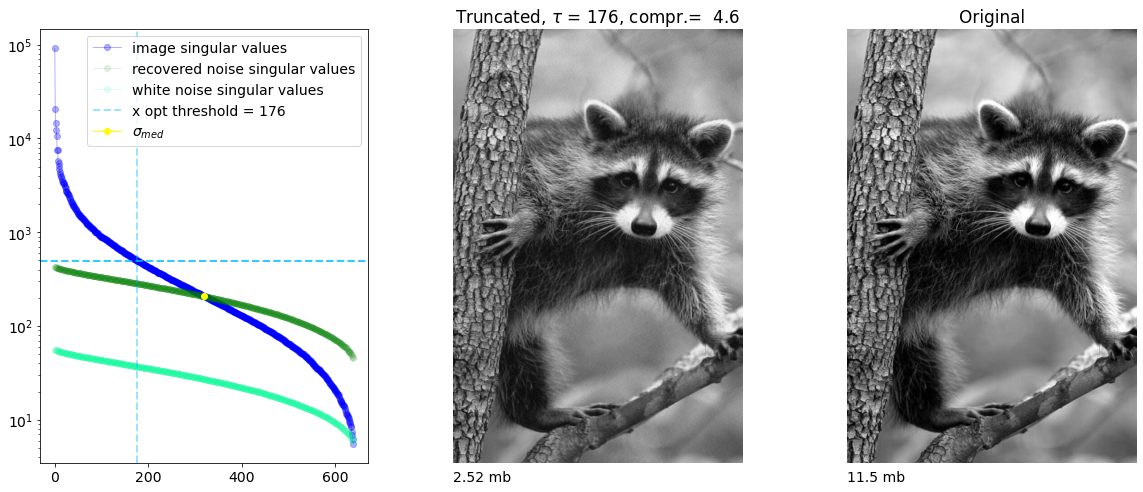

In [29]:
from numpy.linalg import svd
lambda_beta = sqrt(2*(beta + 1) + (8*beta)/(beta + 1 + sqrt(beta**2 + 14*beta + 1)))
omega = lambda_beta / sqrt(mu_median)
U, s, V = svd(image,full_matrices=False) # where s is a vector
cutoff = omega * np.median(s) # tau
r_n = np.max(np.where(s > cutoff))
reconst_img = U[:,:(r_n+1)] @ np.diag(s[:(r_n+1)]) @ V[:(r_n+1),:]

sigma = np.median(s) / sqrt(n * mu_median) # noise magnitude  "sigma * np.random.randn(...) + mu"
noise = sigma * np.random.randn(*image.shape)
U_n, s_n, V_n = svd(noise,full_matrices=False)

white_noise = np.random.randn(*image.shape)
U_wn, s_wn, V_wn = svd(white_noise,full_matrices=False)

plt.rcParams.update({'font.size': 14})
fig,axes = plt.subplots(1,3,figsize=(20,8))

axes[0].semilogy(s,'-o', color='b', linewidth=1, alpha=0.3, label="image singular values")
axes[0].semilogy(s_n,'-o', color='g', linewidth=1, alpha=0.1, label="recovered noise singular values")
axes[0].semilogy(s_wn,'-o', color='mediumspringgreen', linewidth=1, alpha=0.1, label="white noise singular values")
axes[0].axhline(y=cutoff, ls='--', color='deepskyblue', linewidth=2, alpha=0.8)
axes[0].axvline(x=r_n, ls='--', color='deepskyblue', linewidth=2, alpha=0.4, label="x opt threshold = " + str(r_n))
axes[0].semilogy(s.shape[0]/2, np.median(s),'-o', color='yellow', linewidth=1, label= r"$ \sigma_{med} $ ")
axes[0].legend()

original_img_bytes = U.nbytes + np.diag(s).nbytes + V.nbytes
comressed_img_bytes = U[:,:(r_n+1)].nbytes + np.diag(s[:(r_n+1)]).nbytes + V[:(r_n+1),:].nbytes
comression_ratio = original_img_bytes/comressed_img_bytes

axes[1].imshow(reconst_img,cmap='gray')
axes[1].set_title("Truncated, " + r"$ \tau $ = " + str(r_n) + ", compr.=  " + "{:.2}".format(comression_ratio))
axes[1].text(0, 1000, "{:.3}".format((comressed_img_bytes/10e+5)) + ' mb') 
axes[1].axis('off')

axes[2].imshow(image,cmap='gray')
axes[2].set_title('Original')
axes[2].text(0, 1000,"{:.3}".format((original_img_bytes/10e+5)) + ' mb') 
axes[2].axis('off');

We can conclude that the recovered image at the optimal hard threshold $\tau$ = 176 still looks OK. Visually most features are saved (like fur details, glare on the eyes, whiskers, tree bark details and etc.), image became a bit brighter and less contrast. For an image that can be recovered from arrays that have compressed by 4.6 times it looks good enough!

Another observation and reminder is that the cutoff looks like it is slighlty higher than the last largest singular value of the adjusted by the common median singular value of gaussian noise, this is due to the abovementioned $\lambda(\beta)$ adjustment.

Let's now consider more images (from skimage), to ensure that is not a one-time thing:

In [30]:
from skimage import data
from skimage.color import rgb2gray
from skimage import img_as_ubyte, img_as_float
gray_images = {
        "coffee":rgb2gray(img_as_float(data.coffee())),
        "camera":data.camera(),
        "astro":rgb2gray(img_as_float(data.astronaut())),
        "cat":rgb2gray(img_as_float(data.chelsea())),
        "coins": data.coins(),
        "clock":data.clock(),
        "page":data.page()
}

In [31]:
def plot_compressed_img(img_name, cut):
    image=gray_images[img_name] #images

    m = np.min(image.shape)
    n = np.max(image.shape)
    beta = m/n
    mu_median = scipy.optimize.broyden1(lambda x: Marcenko_Pastur_Integral(x,beta)-1/2, 1.0, f_tol=1e-6)
    lambda_beta = sqrt(2*(beta + 1) + (8*beta)/(beta + 1 + sqrt(beta**2 + 14*beta + 1)))
    omega = lambda_beta / sqrt(mu_median)

    U, s, V = svd(image,full_matrices=False) # where 's' is a vector
    max_sing_val = s.shape[0]
    cutoff = omega * np.median(s) # tau
    r_n = np.max(np.where(s > cutoff))
    reconst_img = U[:,:cut] @ np.diag(s[:cut]) @ V[:cut,:]

    sigma = np.median(s) / sqrt(n * mu_median) 
    noise = sigma * np.random.randn(*image.shape) # noise magnitude  "sigma * np.random.randn(...) + mu"
    U_n, s_n, V_n = svd(noise,full_matrices=False)

    white_noise = np.random.randn(*image.shape)
    U_wn, s_wn, V_wn = svd(white_noise,full_matrices=False)

    original_img_bytes = U.nbytes + np.diag(s).nbytes + V.nbytes
    comressed_img_bytes = U[:,:cut].nbytes + np.diag(s[:cut]).nbytes + V[:cut,:].nbytes
    comression_ratio = original_img_bytes/comressed_img_bytes
    
    plt.rcParams.update({'font.size': 14})
    fig,axes = plt.subplots(1,3,figsize=(20,8))

    axes[0].semilogy(s,'-o', color='b', linewidth=1, alpha=0.3, label="original singular values")
    axes[0].semilogy(s_n,'-o', color='g', linewidth=1, alpha=0.1, label="recovered noise singular values")
    axes[0].semilogy(s_wn,'-o', color='mediumspringgreen', linewidth=1, alpha=0.1, label="white noise singular values")
    axes[0].axhline(y=cutoff, ls='--', color='deepskyblue', linewidth=2, alpha=0.8)
    axes[0].axvline(x=r_n, ls='--', color='deepskyblue', linewidth=2, alpha=0.4, label="x opt threshold = " + str(r_n))
    axes[0].semilogy(s.shape[0]/2, np.median(s),'-o', color='yellow', linewidth=1, label= r"$ \sigma_{med} $ ")
    axes[0].legend(loc='upper right', frameon=False)

    axes[1].imshow(reconst_img,cmap='gray')
    axes[1].set_title("Truncated, " + r"$ \tau $ = " + str(cut) + ", compr.=  " + "{:.2}".format(comression_ratio))
    axes[1].text(0, image.shape[0]+30, "{:.3}".format((comressed_img_bytes/10e+5)) + ' mb')
    axes[1].axis('off')

    axes[2].imshow(image,cmap='gray')
    axes[2].set_title('Original')
    axes[2].text(0, image.shape[0]+30,"{:.3}".format((original_img_bytes/10e+5)) + ' mb') 
    axes[2].axis('off')
    plt.show();

Here you need to manually slide the $\tau$ to the calculated otpimal value:

In [32]:
from ipywidgets import interact
interact(plot_compressed_img,img_name=list(gray_images.keys()),cut=(1,400));

interactive(children=(Dropdown(description='img_name', options=('coffee', 'camera', 'astro', 'cat', 'coins', '…

For the first four images the non-adjusted white noise is above the original singular values. Sometimes the shape of the white noise is different to the original shape, its OK.

The image **camera** shows us the 'elbow', it seems that its due to high contrast between light sky gradient and a black coat. Anothe interesting case is met in the **clock** image: seems like the original image is blurred and we have a perfect match in most of the singular values.